Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=8edf09ef3787915bd38ef8a673e3281d31d7ed45af63292d4ee69674dec6beb7
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 32.3 MB/s 
     |████████████████████████████████| 163 kB 56.8 MB/s 
[3183, 2605, 3890, 3945, 4805, 3649, 1176, 2719]
[18, 17, 19

In [ ]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [ ]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-23 03:35:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-23 03:35:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-23 03:35:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [ ]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [ ]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [ ]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [ ]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [ ]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3534 words (3144 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          667900    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 839,192
Trainable params: 839,192
Non-trainable param

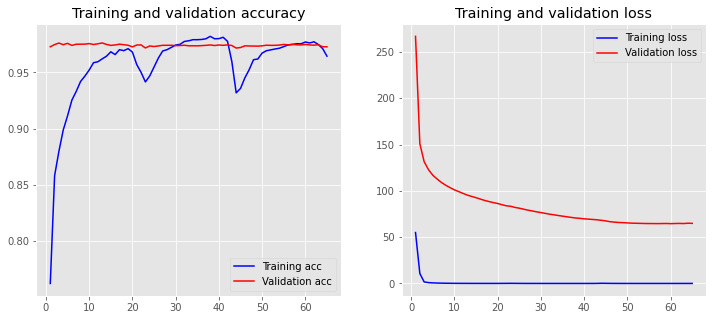

6/6 [==============================] - 3s 76ms/step
F1-score: 74.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4444444444444444,0.5714285714285714,0.5,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.36363636363636365,0.4444444444444444,0.39999999999999997,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.6666666666666666,0.5925925925925926,0.627450980392157,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5,0.75,0.6,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.7085714285714285,0.7848101265822784,0.7447447447447447,316.0
Material-Descriptor,0.5,0.6067415730337079,0.5482233502538071,89.0
Meta,0.23529411764705882,0.3076923076923077,0.26666666666666666,13.0
Nonrecipe-Material,0.2972972972972973,0.44,0.3548387096774193,25.0
Number,0.9

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3552 words (3143 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          669600    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 840,892
Trainable params: 840,892
Non-trainable par

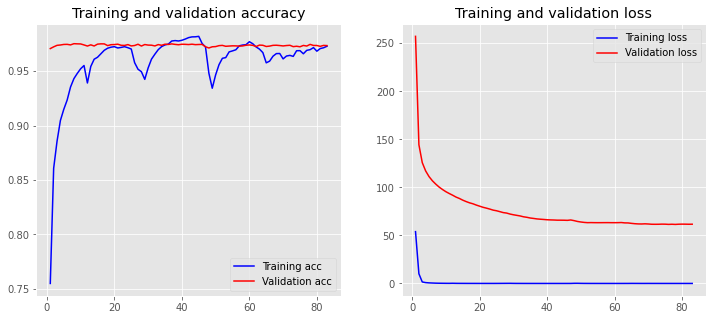

6/6 [==============================] - 3s 79ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.7142857142857143,0.4545454545454545,7.0
Amount-Unit,0.83,0.8469387755102041,0.8383838383838385,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.3488372093023256,0.5555555555555556,0.4285714285714286,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5277777777777778,0.95,0.6785714285714285,20.0
Condition-Type,0.058823529411764705,1.0,0.1111111111111111,1.0
Condition-Unit,0.9247311827956989,0.9885057471264368,0.9555555555555556,87.0
Material,0.7046153846153846,0.7246835443037974,0.7145085803432136,316.0
Material-Descriptor,0.5764705882352941,0.550561797752809,0.5632183908045977,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3545 words (3132 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          667800    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 839,092
Trainable params: 839,092
Non-trainable par

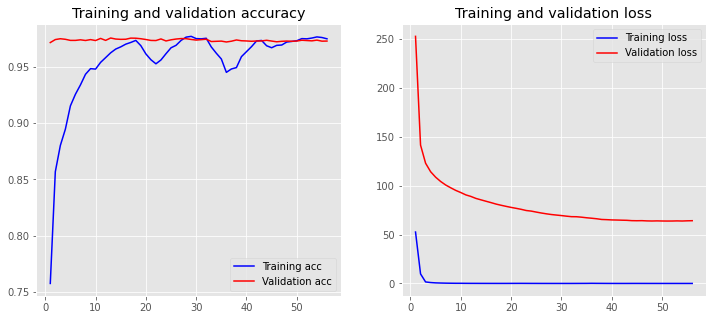

6/6 [==============================] - 3s 80ms/step
F1-score: 74.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.92,0.9387755102040817,0.9292929292929293,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.46153846153846156,0.5454545454545455,13.0
Brand,0.5,0.48148148148148145,0.49056603773584906,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5142857142857142,0.9,0.6545454545454545,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6945244956772334,0.7626582278481012,0.7269984917043739,316.0
Material-Descriptor,0.48695652173913045,0.6292134831460674,0.5490196078431373,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.3142857142857143,0.44,0.36

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3532 words (3132 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          666500    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 837,792
Trainable params: 837,792
Non-trainable par

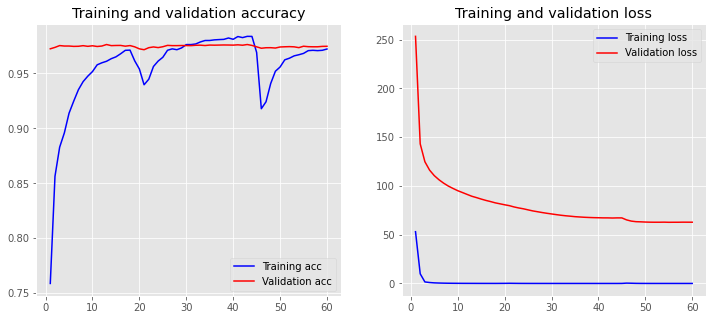

6/6 [==============================] - 3s 82ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8921568627450981,0.9285714285714286,0.9099999999999999,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.07692307692307693,0.14285714285714288,13.0
Brand,0.5517241379310345,0.5925925925925926,0.5714285714285714,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6785714285714286,0.7215189873417721,0.6993865030674846,316.0
Material-Descriptor,0.5333333333333333,0.5393258426966292,0.5363128491620112,89.0
Meta,0.23529411764705882,0.3076923076923077,0.26666666666666666,13.0
Nonrecipe-Material,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3523 words (3141 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          666500    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 837,792
Trainable params: 837,792
Non-trainable par

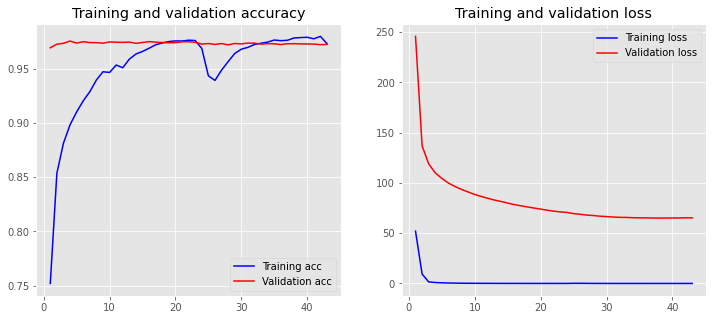

6/6 [==============================] - 3s 77ms/step
F1-score: 73.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.8811881188118812,0.9081632653061225,0.8944723618090452,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.375,0.3333333333333333,0.35294117647058826,27.0
Characterization-Apparatus,0.4,0.18181818181818182,0.25000000000000006,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.0625,1.0,0.11764705882352941,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6574585635359116,0.7531645569620253,0.7020648967551623,316.0
Material-Descriptor,0.5858585858585859,0.651685393258427,0.6170212765957447,89.0
Meta,0.23809523809523808,0.38461538461538464,0.2941176470588235,13.0
Nonrecipe-Material,0.3103

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3544 words (3132 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 158, 100)          667700    
                                                                 
 bidirectional_5 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 838,992
Trainable params: 838,992
Non-trainable par

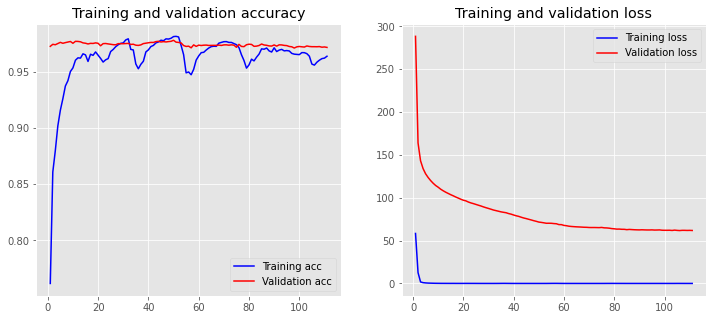

6/6 [==============================] - 3s 82ms/step
F1-score: 72.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.5714285714285714,0.34782608695652173,7.0
Amount-Unit,0.8557692307692307,0.9081632653061225,0.8811881188118811,98.0
Apparatus-Descriptor,0.35714285714285715,0.5555555555555556,0.43478260869565216,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.4444444444444444,0.5925925925925926,0.5079365079365079,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6639784946236559,0.7816455696202531,0.7180232558139535,316.0
Material-Descriptor,0.5,0.6067415730337079,0.5482233502538071,89.0
Meta,0.4166666666666667,0.38461538461538464,0.4,13.0
Nonrecipe-Material,0.2647058823529412,0.36,0.30508474576271183,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3536 words (3150 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 158, 100)          668700    
                                                                 
 bidirectional_6 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 839,992
Trainable params: 839,992
Non-trainable par

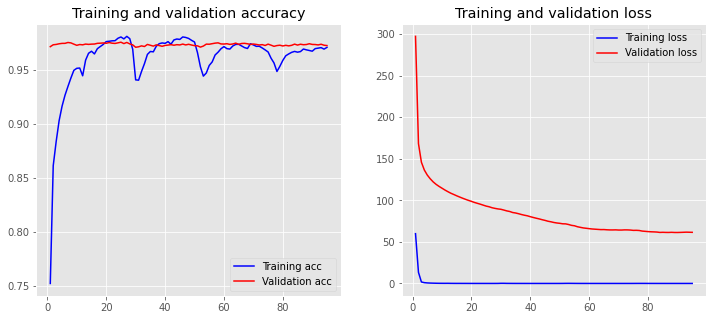

6/6 [==============================] - 3s 83ms/step
F1-score: 72.4%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.23529411764705882,0.5714285714285714,0.3333333333333333,7.0
Amount-Unit,0.8557692307692307,0.9081632653061225,0.8811881188118811,98.0
Apparatus-Descriptor,0.375,0.6666666666666666,0.4800000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.5,0.4444444444444444,0.47058823529411764,27.0
Characterization-Apparatus,0.14285714285714285,0.09090909090909091,0.1111111111111111,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.05263157894736842,1.0,0.1,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6685393258426966,0.7531645569620253,0.7083333333333333,316.0
Material-Descriptor,0.49514563106796117,0.5730337078651685,0.5312499999999999,89.0
Meta,0.2,0.3076923076923077,0.24242424242424246,13.0
Nonrecipe-Material,0.46153846153846156,0.48,0.47058823529411764,25.0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3543 words (3137 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 158, 100)          668100    
                                                                 
 bidirectional_7 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 839,392
Trainable params: 839,392
Non-trainable par

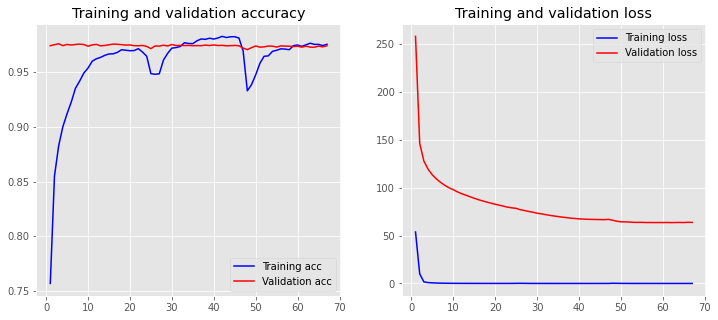

6/6 [==============================] - 3s 79ms/step
F1-score: 74.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.8640776699029126,0.9081632653061225,0.8855721393034826,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.3333333333333333,0.16666666666666666,0.2222222222222222,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.7391304347826086,0.6296296296296297,0.68,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.68,0.85,0.7555555555555556,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6805555555555556,0.7753164556962026,0.7248520710059172,316.0
Material-Descriptor,0.4732142857142857,0.5955056179775281,0.527363184079602,89.0
Meta,0.38461538461538464,0.38461538461538464,0.38461538

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3534 words (3146 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 158, 100)          668100    
                                                                 
 bidirectional_8 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 839,392
Trainable params: 839,392
Non-trainable par

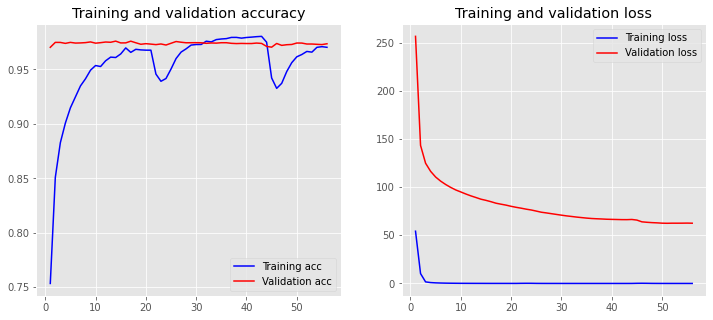

6/6 [==============================] - 3s 79ms/step
F1-score: 73.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.8543689320388349,0.8979591836734694,0.8756218905472637,98.0
Apparatus-Descriptor,0.46153846153846156,0.6666666666666666,0.5454545454545455,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.42857142857142855,0.23076923076923078,0.3,13.0
Brand,0.6190476190476191,0.48148148148148145,0.5416666666666666,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.06666666666666667,1.0,0.125,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6538461538461539,0.7531645569620253,0.7000000000000001,316.0
Material-Descriptor,0.5473684210526316,0.5842696629213483,0.5652173913043478,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Converted 3538 words (3130 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 158, 100)          666900    
                                                                 
 bidirectional_9 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 838,192
Trainable params: 838,192
Non-trainable par

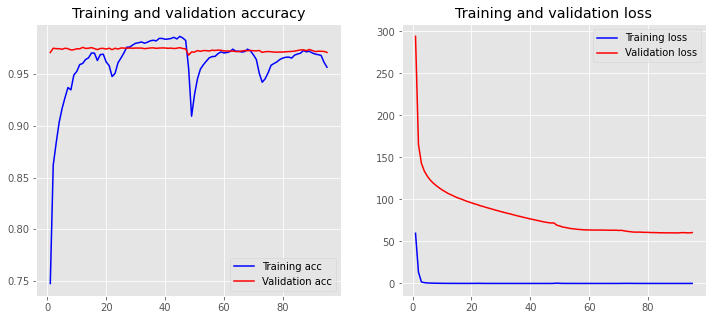

6/6 [==============================] - 3s 83ms/step
F1-score: 71.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.35714285714285715,0.7142857142857143,0.4761904761904762,7.0
Amount-Unit,0.8543689320388349,0.8979591836734694,0.8756218905472637,98.0
Apparatus-Descriptor,0.3333333333333333,0.4444444444444444,0.380952380952381,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.6,0.4444444444444444,0.5106382978723405,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6129032258064516,0.95,0.7450980392156863,20.0
Condition-Type,0.0625,1.0,0.11764705882352941,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6695652173913044,0.7310126582278481,0.6989409984871408,316.0
Material-Descriptor,0.44545454545454544,0.550561797752809,0.49246231155778897,89.0
Meta,0.25,0.3076923076923077,0.27586206896551724,13.0
Nonrecipe-Material,0.3125,0.4,0.350877192982

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3603 words (3158 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 158, 100)          676200    
                                                                 
 bidirectional_10 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 847,492
Trainable params: 847,492
Non-trainable pa

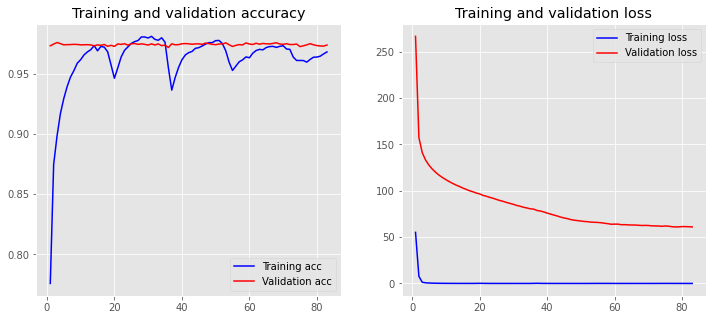

6/6 [==============================] - 3s 85ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.8557692307692307,0.9081632653061225,0.8811881188118811,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.4230769230769231,0.4074074074074074,0.4150943396226415,27.0
Characterization-Apparatus,0.1111111111111111,0.09090909090909091,0.09999999999999999,11.0
Condition-Misc,0.6206896551724138,0.9,0.7346938775510204,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.659400544959128,0.7658227848101266,0.7086383601756956,316.0
Material-Descriptor,0.5783132530120482,0.5393258426966292,0.5581395348837208,89.0
Meta,0.13043478260869565,0.23076923076923078,0.16666666666

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3603 words (3158 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 158, 100)          676200    
                                                                 
 bidirectional_11 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 847,492
Trainable params: 847,492
Non-trainable pa

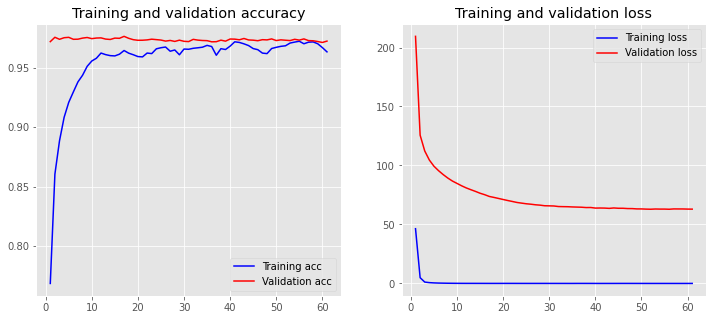

6/6 [==============================] - 4s 83ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.8679245283018868,0.9387755102040817,0.9019607843137256,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.5185185185185185,0.5185185185185185,0.5185185185185185,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5714285714285714,0.8,0.6666666666666666,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6602209944751382,0.7563291139240507,0.7050147492625369,316.0
Material-Descriptor,0.4835164835164835,0.4943820224719101,0.48888888888888893,89.0
Meta,0.25,0.38461538461538464,0.303030303

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3594 words (3152 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 158, 100)          674700    
                                                                 
 bidirectional_12 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 845,992
Trainable params: 845,992
Non-trainable pa

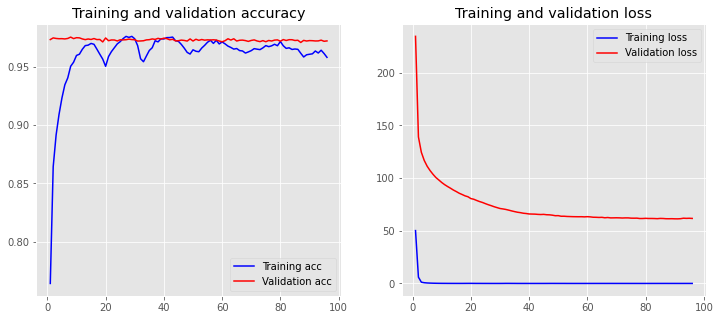

6/6 [==============================] - 3s 82ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4444444444444444,0.5714285714285714,0.5,7.0
Amount-Unit,0.8712871287128713,0.8979591836734694,0.8844221105527638,98.0
Apparatus-Descriptor,0.4,0.4444444444444444,0.4210526315789474,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.47368421052631576,0.3333333333333333,0.391304347826087,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.7009345794392523,0.7120253164556962,0.706436420722135,316.0
Material-Descriptor,0.49074074074074076,0.5955056179775281,0.5380710659898478,89.0
Meta,0.29411764705882354,0.38461538461538464,0.333333333

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3599 words (3168 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 158, 100)          676800    
                                                                 
 bidirectional_13 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 848,092
Trainable params: 848,092
Non-trainable pa

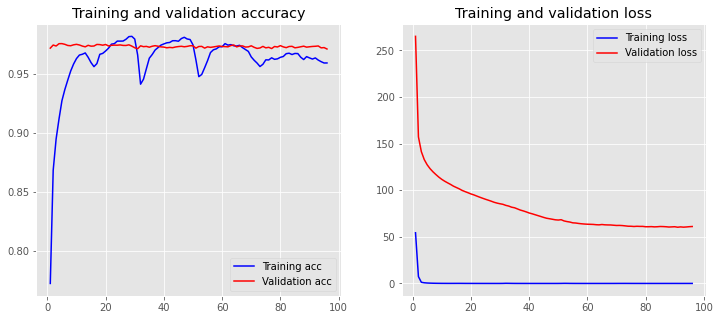

6/6 [==============================] - 4s 80ms/step
F1-score: 72.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.35714285714285715,0.7142857142857143,0.4761904761904762,7.0
Amount-Unit,0.8431372549019608,0.8775510204081632,0.86,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.3076923076923077,0.47058823529411764,13.0
Brand,0.47058823529411764,0.2962962962962963,0.3636363636363636,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.6296296296296297,0.85,0.723404255319149,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6256410256410256,0.7721518987341772,0.6912181303116147,316.0
Material-Descriptor,0.5151515151515151,0.5730337078651685,0.5425531914893618,89.0
Meta,0.19047619047619047,0.3076923076923077,0.235294117

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3605 words (3153 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 158, 100)          675900    
                                                                 
 bidirectional_14 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 847,192
Trainable params: 847,192
Non-trainable pa

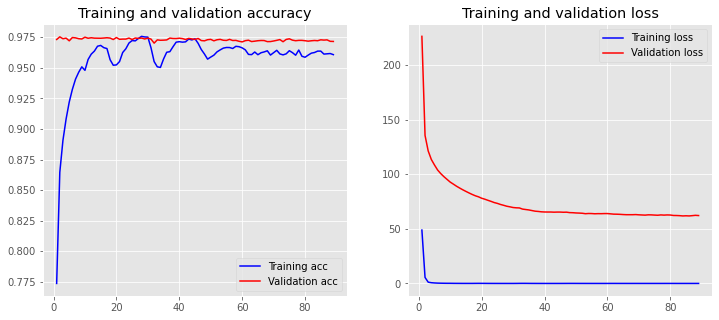

6/6 [==============================] - 3s 80ms/step
F1-score: 71.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.2857142857142857,0.26666666666666666,7.0
Amount-Unit,0.8514851485148515,0.8775510204081632,0.864321608040201,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.3055555555555556,0.4074074074074074,0.3492063492063492,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.6206896551724138,0.9,0.7346938775510204,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6358695652173914,0.740506329113924,0.6842105263157895,316.0
Material-Descriptor,0.53,0.5955056179775281,0.5608465608465608,89.0
Meta,0.19047619047619047,0.3076923076923077,0.23529411764705882,13.0
Nonrecipe-Material,0.3125,0.4,0.3508771929824561,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3611 words (3160 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 158, 100)          677200    
                                                                 
 bidirectional_15 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 848,492
Trainable params: 848,492
Non-trainable pa

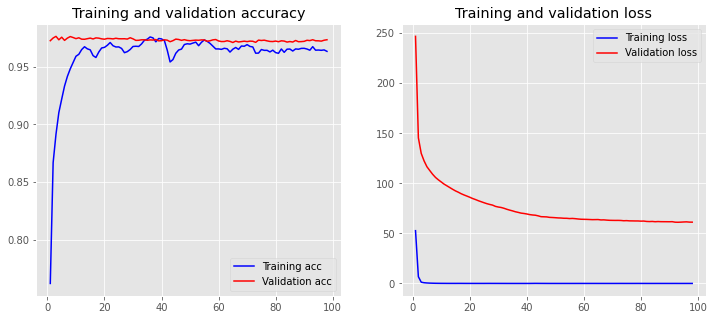

6/6 [==============================] - 4s 81ms/step
F1-score: 72.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.5714285714285714,0.38095238095238093,7.0
Amount-Unit,0.8514851485148515,0.8775510204081632,0.864321608040201,98.0
Apparatus-Descriptor,0.35714285714285715,0.5555555555555556,0.43478260869565216,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.6153846153846154,0.5925925925925926,0.6037735849056604,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9550561797752809,0.9770114942528736,0.9659090909090908,87.0
Material,0.6638655462184874,0.75,0.7043090638930164,316.0
Material-Descriptor,0.46788990825688076,0.5730337078651685,0.5151515151515151,89.0
Meta,0.36363636363636365,0.3076923076923077,0.33333333333333337,13.0
Nonrecipe-Mat

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3622 words (3156 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 158, 100)          677900    
                                                                 
 bidirectional_16 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 849,192
Trainable params: 849,192
Non-trainable pa

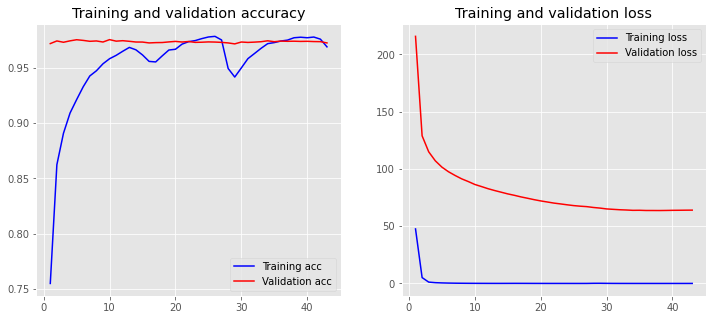

6/6 [==============================] - 3s 82ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.8571428571428571,0.9183673469387755,0.8866995073891625,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.4,0.2962962962962963,0.3404255319148936,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.6129032258064516,0.95,0.7450980392156863,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6552631578947369,0.7879746835443038,0.7155172413793104,316.0
Material-Descriptor,0.5,0.5730337078651685,0.5340314136125655,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
No

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3617 words (3150 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 158, 100)          676800    
                                                                 
 bidirectional_17 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 848,092
Trainable params: 848,092
Non-trainable pa

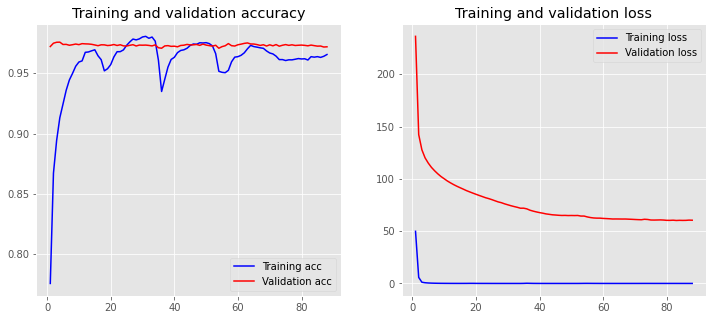

6/6 [==============================] - 4s 81ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.8725490196078431,0.9081632653061225,0.89,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.3902439024390244,0.5925925925925926,0.47058823529411764,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.625,0.75,0.6818181818181818,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9550561797752809,0.9770114942528736,0.9659090909090908,87.0
Material,0.6585365853658537,0.7689873417721519,0.7094890510948905,316.0
Material-Descriptor,0.47058823529411764,0.5393258426966292,0.5026178010471204,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.45454545454545453,0.4,0.4255319148936171,25.0
Number,0.9333333333333333

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3613 words (3161 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 158, 100)          677500    
                                                                 
 bidirectional_18 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 848,792
Trainable params: 848,792
Non-trainable pa

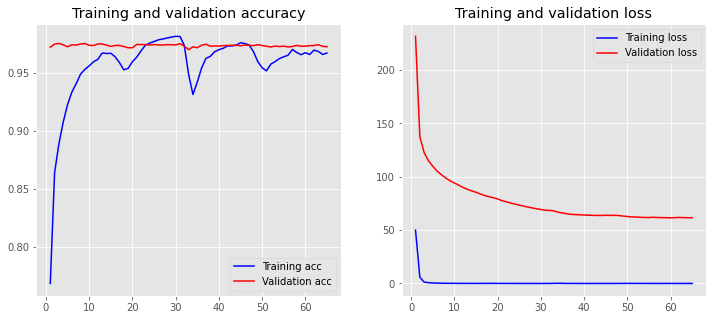

6/6 [==============================] - 4s 93ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.82,0.8367346938775511,0.8282828282828283,98.0
Apparatus-Descriptor,0.3333333333333333,0.5555555555555556,0.4166666666666667,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.26666666666666666,0.2962962962962963,0.28070175438596495,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5135135135135135,0.95,0.6666666666666667,20.0
Condition-Type,0.0625,1.0,0.11764705882352941,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.6779661016949152,0.759493670886076,0.7164179104477613,316.0
Material-Descriptor,0.4322033898305085,0.5730337078651685,0.49275362318840576,89.0
Meta,0.15,0.23076923076923078,0.18181818181818185,13.0
Nonrecipe-Material,0.30303030303030304,0.4,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Converted 3610 words (3167 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 158, 100)          677800    
                                                                 
 bidirectional_19 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 849,092
Trainable params: 849,092
Non-trainable pa

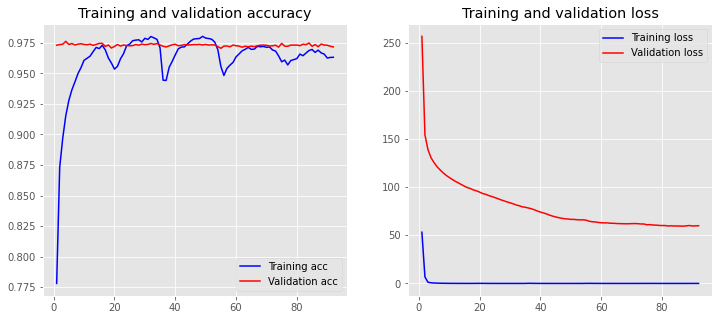

6/6 [==============================] - 4s 84ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2777777777777778,0.7142857142857143,0.4,7.0
Amount-Unit,0.8256880733944955,0.9183673469387755,0.8695652173913043,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.35714285714285715,0.37037037037037035,0.36363636363636365,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9655172413793104,0.9655172413793104,0.9655172413793104,87.0
Material,0.6378378378378379,0.7468354430379747,0.6880466472303207,316.0
Material-Descriptor,0.4375,0.550561797752809,0.4875621890547264,89.0
Meta,0.3333333333333333,0.38461538461538464,0.3571428571428571,13.0
Nonrecipe-Material,0.35

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3674 words (3172 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 158, 100)          684700    
                                                                 
 bidirectional_20 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 855,992
Trainable params: 855,992
Non-trainable pa

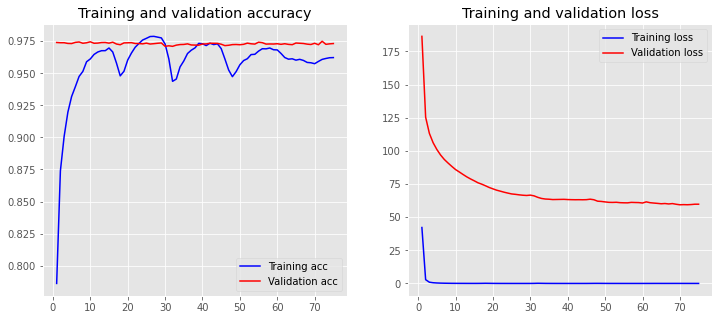

6/6 [==============================] - 4s 83ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.45454545454545453,0.7142857142857143,0.5555555555555556,7.0
Amount-Unit,0.8613861386138614,0.8877551020408163,0.8743718592964823,98.0
Apparatus-Descriptor,0.6,0.6666666666666666,0.631578947368421,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.47619047619047616,0.37037037037037035,0.4166666666666667,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.48484848484848486,0.8,0.6037735849056605,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9545454545454546,0.9655172413793104,0.96,87.0
Material,0.6482939632545932,0.7816455696202531,0.708751793400287,316.0
Material-Descriptor,0.47572815533980584,0.550561797752809,0.5104166666666666,89.0
Meta,0.23076923076923078,0.23076923076923078,0.23076

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3666 words (3176 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 158, 100)          684300    
                                                                 
 bidirectional_21 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 855,592
Trainable params: 855,592
Non-trainable pa

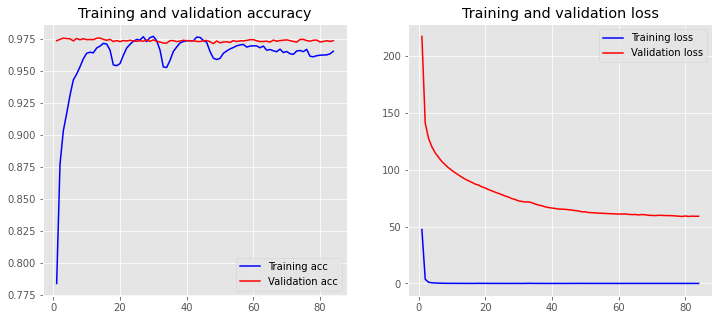

6/6 [==============================] - 4s 80ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.8461538461538461,0.8979591836734694,0.8712871287128713,98.0
Apparatus-Descriptor,0.42857142857142855,0.6666666666666666,0.5217391304347826,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5294117647058824,0.3333333333333333,0.409090909090909,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.8947368421052632,0.9770114942528736,0.9340659340659342,87.0
Material,0.6584699453551912,0.7626582278481012,0.7067448680351904,316.0
Material-Descriptor,0.45,0.5056179775280899,0.47619047619047616,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Mat

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3673 words (3183 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 158, 100)          685700    
                                                                 
 bidirectional_22 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 856,992
Trainable params: 856,992
Non-trainable pa

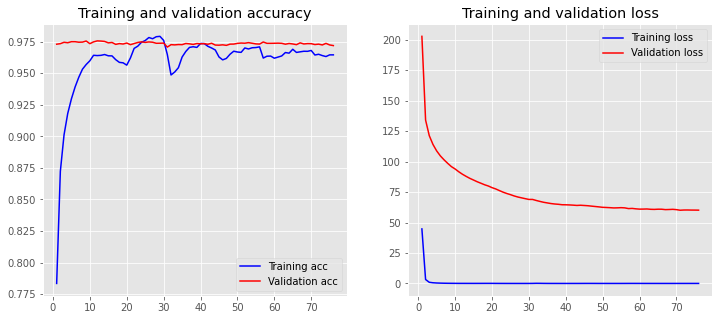

6/6 [==============================] - 4s 83ms/step
F1-score: 72.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.9081632653061225,0.9081632653061225,0.9081632653061225,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.6818181818181818,0.5555555555555556,0.6122448979591836,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.4444444444444444,0.8,0.5714285714285714,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.6676136363636364,0.7436708860759493,0.7035928143712575,316.0
Material-Descriptor,0.4891304347826087,0.5056179775280899,0.4972375690607735,89.0
Meta,0.25,0.3076923076923077,0.27586206896551724,13.0
N

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3686 words (3175 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 158, 100)          686200    
                                                                 
 bidirectional_23 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 857,492
Trainable params: 857,492
Non-trainable pa

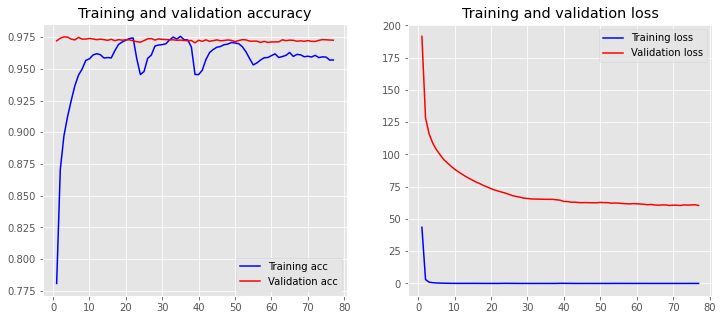

6/6 [==============================] - 4s 80ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.5714285714285714,0.38095238095238093,7.0
Amount-Unit,0.8712871287128713,0.8979591836734694,0.8844221105527638,98.0
Apparatus-Descriptor,0.36363636363636365,0.4444444444444444,0.39999999999999997,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.6153846153846154,0.5925925925925926,0.6037735849056604,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.4722222222222222,0.85,0.6071428571428571,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.670299727520436,0.7784810126582279,0.7203513909224012,316.0
Material-Descriptor,0.48314606741573035,0.48314606741573035,0.48314606741573035,89.0
Meta,0.2222222222222222,0.307692307

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3631 words (3175 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 158, 100)          680700    
                                                                 
 bidirectional_24 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 851,992
Trainable params: 851,992
Non-trainable pa

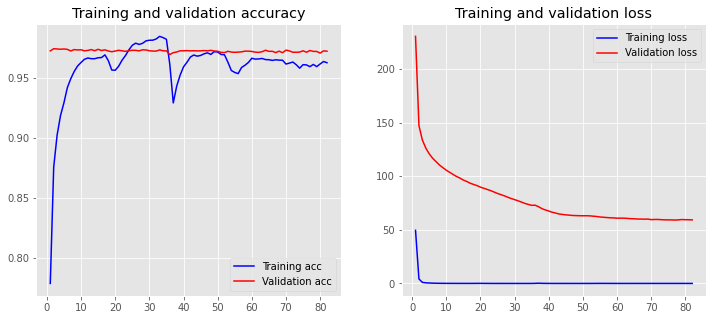

6/6 [==============================] - 4s 85ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.42857142857142855,0.375,7.0
Amount-Unit,0.8584905660377359,0.9285714285714286,0.8921568627450982,98.0
Apparatus-Descriptor,0.3333333333333333,0.3333333333333333,0.3333333333333333,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.3157894736842105,0.2222222222222222,0.2608695652173913,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.5974683544303797,0.7468354430379747,0.6638537271448662,316.0
Material-Descriptor,0.49,0.550561797752809,0.5185185185185186,89.0
Meta,0.15789473684210525,0.23076923076923078,0.18749999999999997,13.0
Nonrecipe-Ma

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3657 words (3174 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 158, 100)          683200    
                                                                 
 bidirectional_25 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 854,492
Trainable params: 854,492
Non-trainable pa

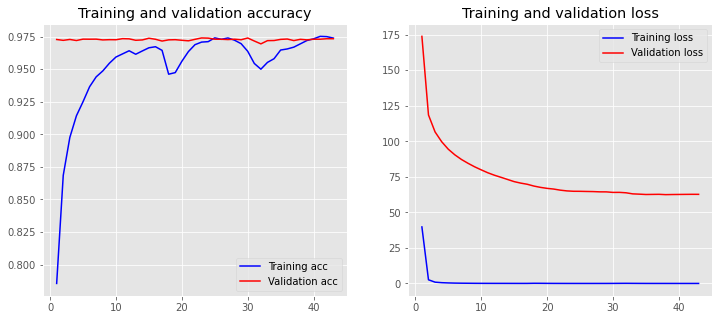

6/6 [==============================] - 4s 85ms/step
F1-score: 73.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.5714285714285714,0.38095238095238093,7.0
Amount-Unit,0.8787878787878788,0.8877551020408163,0.8832487309644671,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.4230769230769231,0.4074074074074074,0.4150943396226415,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.6428571428571429,0.9,0.75,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.6862170087976539,0.740506329113924,0.7123287671232876,316.0
Material-Descriptor,0.5247524752475248,0.5955056179775281,0.5578947368421053,89.0
Meta,0.26666666666666666,0.3076923076923

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3650 words (3166 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 158, 100)          681700    
                                                                 
 bidirectional_26 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 852,992
Trainable params: 852,992
Non-trainable pa

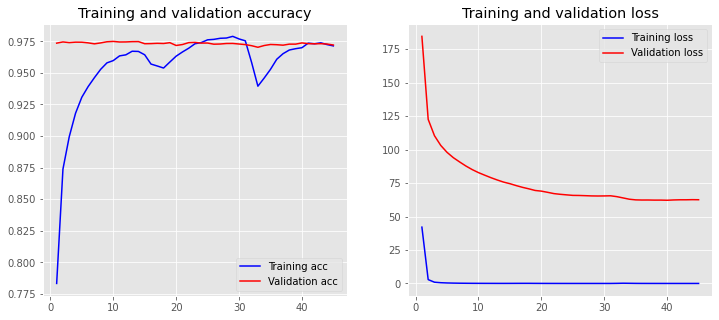

6/6 [==============================] - 3s 80ms/step
F1-score: 74.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8888888888888888,0.8979591836734694,0.8934010152284263,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.65,0.48148148148148145,0.553191489361702,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6721311475409836,0.7784810126582279,0.7214076246334311,316.0
Material-Descriptor,0.4787234042553192,0.5056179775280899,0.49180327868852464,89.0
Meta,0.2222222222222222,0.3076923076923077,0.2580645161290323,13.0
Nonrecipe-Material,0.45454545454545453,0.4,0.4

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3676 words (3190 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 158, 100)          686700    
                                                                 
 bidirectional_27 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 857,992
Trainable params: 857,992
Non-trainable pa

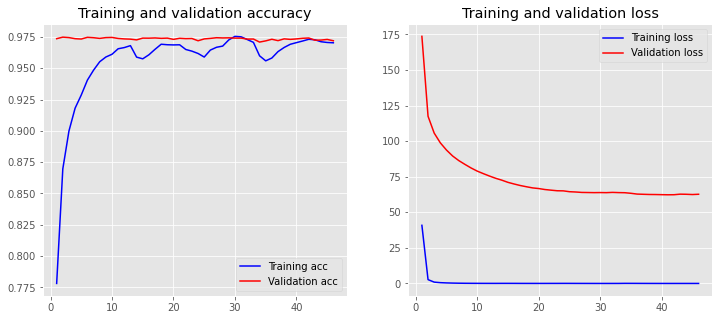

6/6 [==============================] - 3s 81ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.875,0.9285714285714286,0.900990099009901,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.4090909090909091,0.3333333333333333,0.36734693877551017,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5517241379310345,0.8,0.6530612244897959,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.664804469273743,0.7531645569620253,0.7062314540059346,316.0
Material-Descriptor,0.5104166666666666,0.550561797752809,0.5297297297297298,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
Nonrecipe-Material,0.444444444444

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3657 words (3178 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 158, 100)          683600    
                                                                 
 bidirectional_28 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 854,892
Trainable params: 854,892
Non-trainable pa

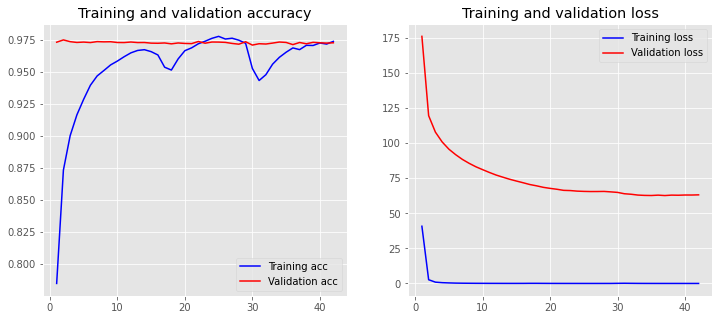

6/6 [==============================] - 3s 83ms/step
F1-score: 72.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.8118811881188119,0.8367346938775511,0.8241206030150754,98.0
Apparatus-Descriptor,0.6666666666666666,0.6666666666666666,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.6,0.5555555555555556,0.576923076923077,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5428571428571428,0.95,0.6909090909090908,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9655172413793104,0.9655172413793104,0.9655172413793104,87.0
Material,0.6666666666666666,0.7341772151898734,0.6987951807228916,316.0
Material-Descriptor,0.5227272727272727,0.5168539325842697,0.519774011299435,89.0
Meta,0.21052631578947367,0.3076923076923

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Converted 3667 words (3166 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 158, 100)          683400    
                                                                 
 bidirectional_29 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 854,692
Trainable params: 854,692
Non-trainable pa

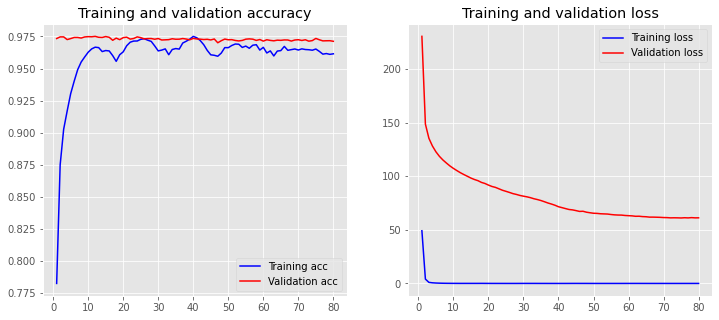

6/6 [==============================] - 3s 81ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4166666666666667,0.7142857142857143,0.5263157894736842,7.0
Amount-Unit,0.8910891089108911,0.9183673469387755,0.9045226130653267,98.0
Apparatus-Descriptor,0.36363636363636365,0.4444444444444444,0.39999999999999997,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.46153846153846156,0.5714285714285714,13.0
Brand,0.5,0.4444444444444444,0.47058823529411764,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6129032258064516,0.95,0.7450980392156863,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6694444444444444,0.7626582278481012,0.7130177514792898,316.0
Material-Descriptor,0.4752475247524752,0.5393258426966292,0.5052631578947369,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Material

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3720 words (3191 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          691200    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 862,492
Trainable params: 862,492
Non-trainable param

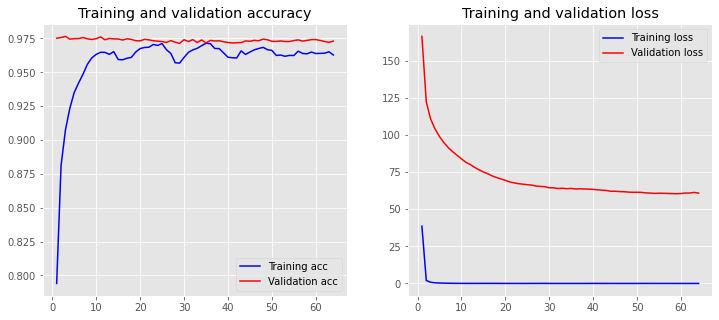

6/6 [==============================] - 4s 84ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3,0.42857142857142855,0.3529411764705882,7.0
Amount-Unit,0.8673469387755102,0.8673469387755102,0.8673469387755102,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.34782608695652173,0.2962962962962963,0.31999999999999995,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.6538461538461539,0.85,0.7391304347826088,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.945054945054945,0.9885057471264368,0.9662921348314606,87.0
Material,0.639344262295082,0.740506329113924,0.6862170087976539,316.0
Material-Descriptor,0.5257731958762887,0.5730337078651685,0.5483870967741935,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Mate

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3704 words (3186 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          689100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 860,392
Trainable params: 860,392
Non-trainable par

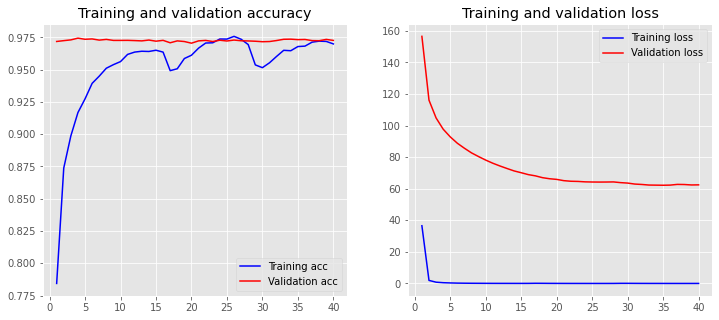

6/6 [==============================] - 4s 92ms/step
F1-score: 72.2%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8317757009345794,0.9081632653061225,0.8682926829268293,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.4583333333333333,0.4074074074074074,0.4313725490196078,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.48484848484848486,0.8,0.6037735849056605,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6675977653631285,0.7563291139240507,0.7091988130563798,316.0
Material-Descriptor,0.4953271028037383,0.5955056179775281,0.5408163265306123,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.3111111111111111,0.56,0.4,25.0
Number,0.9216589861751152,0.9433962264150944,0.9324009324009325,21

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3684 words (3187 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          687200    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 858,492
Trainable params: 858,492
Non-trainable par

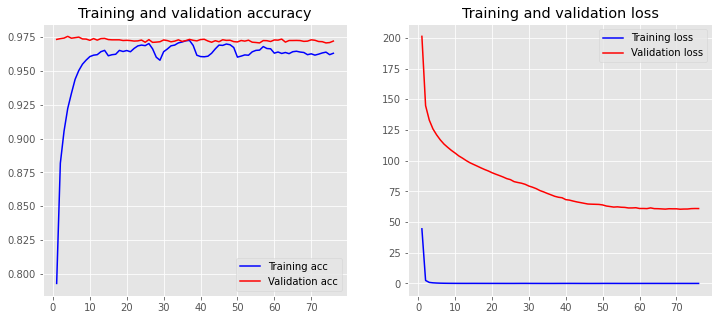

6/6 [==============================] - 4s 85ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.5714285714285714,0.34782608695652173,7.0
Amount-Unit,0.8888888888888888,0.8979591836734694,0.8934010152284263,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.52,0.48148148148148145,0.5,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6684782608695652,0.7784810126582279,0.7192982456140352,316.0
Material-Descriptor,0.4411764705882353,0.5056179775280899,0.4712041884816754,89.0
Meta,0.23529411764705882,0.3076923076923077,0.26666666666666666,13.0
Nonrecipe-Material,0.3333333333333333,0.32,0.32653061224489

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3701 words (3196 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          689800    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 861,092
Trainable params: 861,092
Non-trainable par

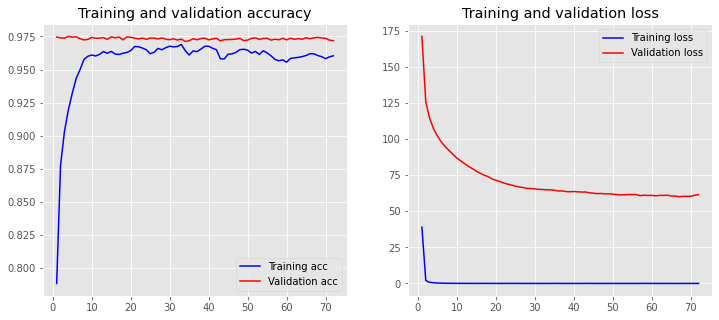

6/6 [==============================] - 4s 80ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.8461538461538461,0.8979591836734694,0.8712871287128713,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.43478260869565216,0.37037037037037035,0.39999999999999997,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6538461538461539,0.85,0.7391304347826088,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.8913043478260869,0.9425287356321839,0.9162011173184358,87.0
Material,0.6786786786786787,0.7151898734177216,0.6964560862865948,316.0
Material-Descriptor,0.46,0.5168539325842697,0.4867724867724868,89.0
Meta,0.38461538461538464,0.38461538461538464,0.38461538461538464,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3703 words (3192 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          689600    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 860,892
Trainable params: 860,892
Non-trainable par

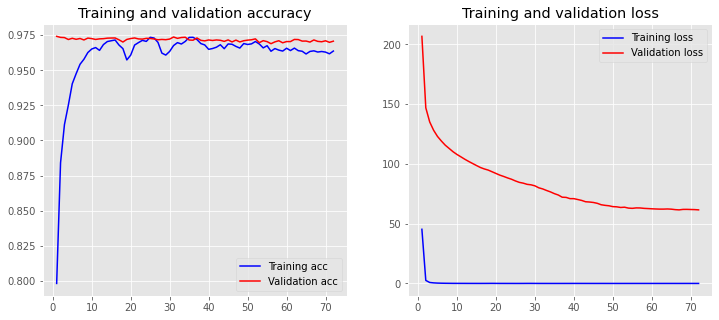

6/6 [==============================] - 4s 82ms/step
F1-score: 70.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.2857142857142857,0.23529411764705882,7.0
Amount-Unit,0.8712871287128713,0.8979591836734694,0.8844221105527638,98.0
Apparatus-Descriptor,0.29411764705882354,0.5555555555555556,0.3846153846153846,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.07692307692307693,0.13333333333333336,13.0
Brand,0.25925925925925924,0.25925925925925924,0.25925925925925924,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6925373134328359,0.7341772151898734,0.7127496159754224,316.0
Material-Descriptor,0.43119266055045874,0.5280898876404494,0.4747474747474747,89.0
Meta,0.16666666666666666,0.23076923076923078,0.1935483870967742,13.0
Nonrecipe-Material,0.2391304347826087,0.44,0.309859154929

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3724 words (3188 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 158, 100)          691300    
                                                                 
 bidirectional_5 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 862,592
Trainable params: 862,592
Non-trainable par

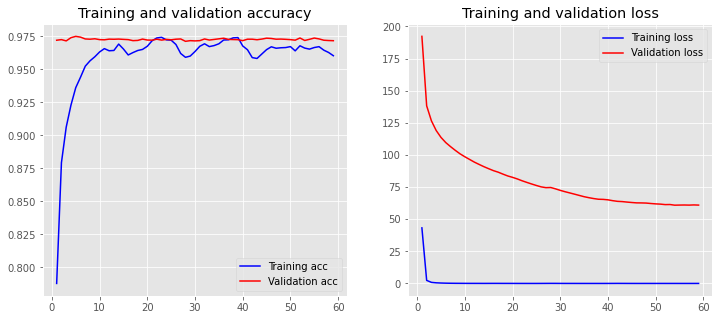

6/6 [==============================] - 4s 84ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.5714285714285714,0.5333333333333333,7.0
Amount-Unit,0.8888888888888888,0.8979591836734694,0.8934010152284263,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.44,0.4074074074074074,0.4230769230769231,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6473829201101928,0.7436708860759493,0.6921944035346097,316.0
Material-Descriptor,0.5263157894736842,0.449438202247191,0.48484848484848486,89.0
Meta,0.21428571428571427,0.23076923076923078,0.22222222222222224,13.0
Nonrecipe-Material,0.35714285714285715,0.4,0.3773

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3692 words (3189 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 158, 100)          688200    
                                                                 
 bidirectional_6 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 859,492
Trainable params: 859,492
Non-trainable par

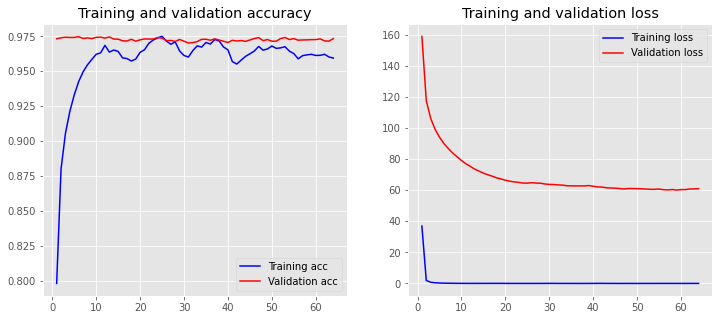

6/6 [==============================] - 4s 81ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.8846153846153846,0.9387755102040817,0.9108910891089108,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.45454545454545453,0.37037037037037035,0.40816326530612246,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.4722222222222222,0.85,0.6071428571428571,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6487935656836461,0.7658227848101266,0.7024673439767779,316.0
Material-Descriptor,0.5053763440860215,0.5280898876404494,0.5164835164835165,89.0
Meta,0.23529411764705882,0.3076923076923077,0.26666666666666666,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3691 words (3187 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 158, 100)          687900    
                                                                 
 bidirectional_7 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 859,192
Trainable params: 859,192
Non-trainable par

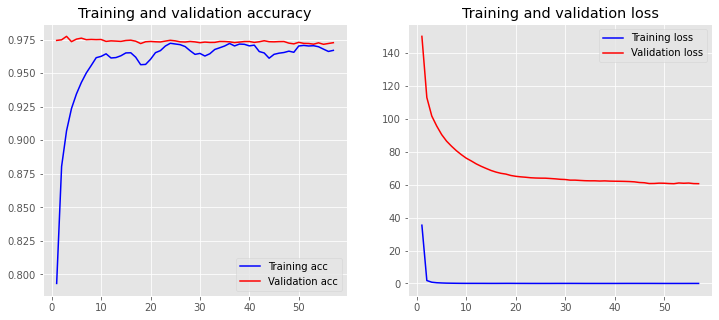

6/6 [==============================] - 4s 84ms/step
F1-score: 72.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.5714285714285714,0.5333333333333333,7.0
Amount-Unit,0.86,0.8775510204081632,0.8686868686868686,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.5555555555555556,0.37037037037037035,0.4444444444444445,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6272493573264781,0.7721518987341772,0.6921985815602836,316.0
Material-Descriptor,0.4943820224719101,0.4943820224719101,0.4943820224719101,89.0
Meta,0.23076923076923078,0.23076923076923078,0.23076923076923078,13.0
Nonrecipe-Material,0.3076923076923077,0.32,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3716 words (3200 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 158, 100)          691700    
                                                                 
 bidirectional_8 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 862,992
Trainable params: 862,992
Non-trainable par

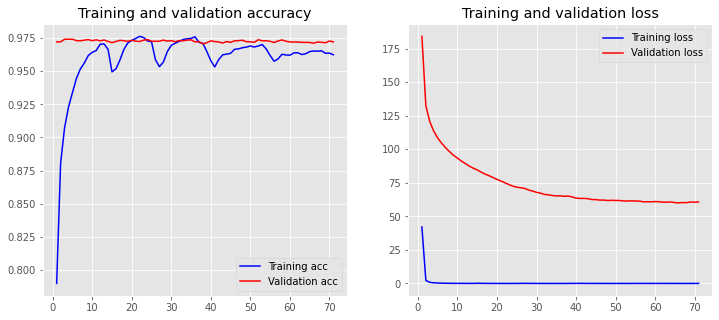

6/6 [==============================] - 4s 82ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.21052631578947367,0.5714285714285714,0.3076923076923077,7.0
Amount-Unit,0.8787878787878788,0.8877551020408163,0.8832487309644671,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.5882352941176471,0.37037037037037035,0.45454545454545453,27.0
Characterization-Apparatus,0.2,0.18181818181818182,0.1904761904761905,11.0
Condition-Misc,0.4444444444444444,0.8,0.5714285714285714,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9318181818181818,0.9425287356321839,0.9371428571428572,87.0
Material,0.6452513966480447,0.7310126582278481,0.685459940652819,316.0
Material-Descriptor,0.42424242424242425,0.47191011235955055,0.4468085106382979,89.0
Meta,0.23529411764705882,0.3076923076923077,0.2666666

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3694 words (3191 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 158, 100)          688600    
                                                                 
 bidirectional_9 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 859,892
Trainable params: 859,892
Non-trainable par

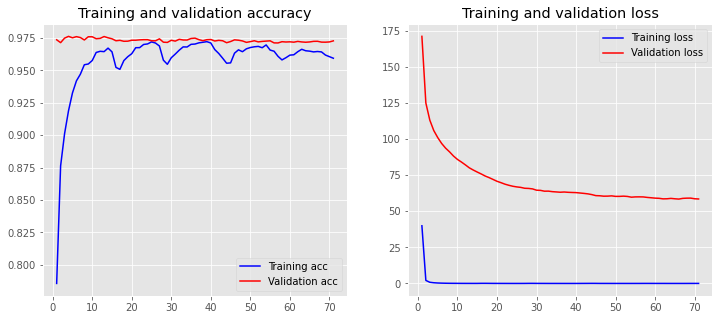

6/6 [==============================] - 3s 80ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.7142857142857143,0.588235294117647,7.0
Amount-Unit,0.8543689320388349,0.8979591836734694,0.8756218905472637,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.3333333333333333,0.37037037037037035,0.3508771929824561,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5454545454545454,0.9,0.679245283018868,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6696165191740413,0.7183544303797469,0.6931297709923664,316.0
Material-Descriptor,0.4423076923076923,0.5168539325842697,0.4766839378238342,89.0
Meta,0.3333333333333333,0.46153846153846156,0.3870967741935484,13.0
Nonreci

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3878 words (3236 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 158, 100)          711500    
                                                                 
 bidirectional_10 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 882,792
Trainable params: 882,792
Non-trainable pa

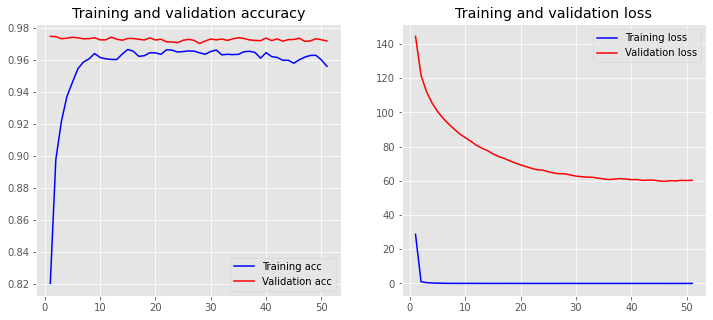

6/6 [==============================] - 3s 80ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.8712871287128713,0.8979591836734694,0.8844221105527638,98.0
Apparatus-Descriptor,0.5714285714285714,0.4444444444444444,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.3684210526315789,0.25925925925925924,0.30434782608695654,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6771428571428572,0.75,0.7117117117117118,316.0
Material-Descriptor,0.4537037037037037,0.550561797752809,0.49746192893401014,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3881 words (3239 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 158, 100)          712100    
                                                                 
 bidirectional_11 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 883,392
Trainable params: 883,392
Non-trainable pa

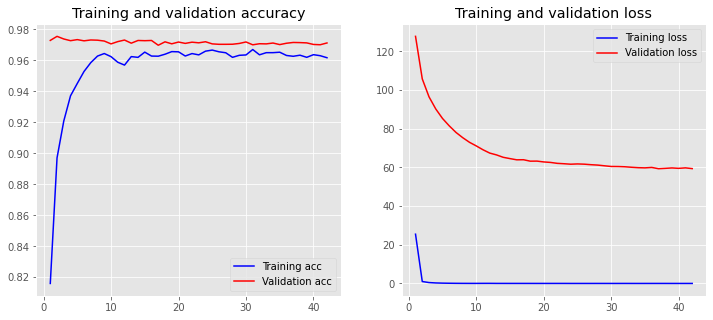

6/6 [==============================] - 3s 79ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8514851485148515,0.8775510204081632,0.864321608040201,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.3888888888888889,0.25925925925925924,0.3111111111111111,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9534883720930233,0.9425287356321839,0.9479768786127168,87.0
Material,0.6388140161725068,0.75,0.6899563318777292,316.0
Material-Descriptor,0.4489795918367347,0.4943820224719101,0.4705882352941177,89.0
Meta,0.3333333333333333,0.46153846153846156,0.3870967741935484,13.0
Nonrecipe-Material,0.2727272727272727,0.36,0.3103448275862069,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3866 words (3241 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 158, 100)          710800    
                                                                 
 bidirectional_12 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 882,092
Trainable params: 882,092
Non-trainable pa

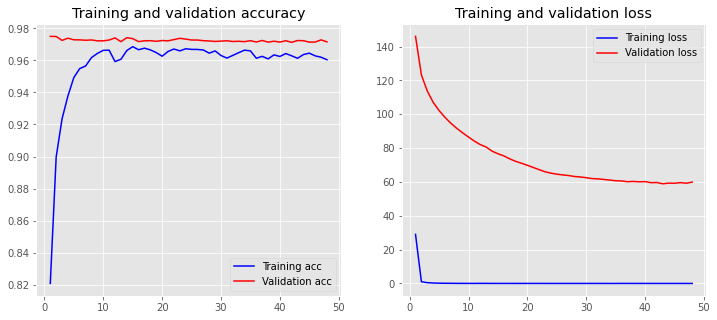

6/6 [==============================] - 3s 79ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.375,0.42857142857142855,0.39999999999999997,7.0
Amount-Unit,0.89,0.9081632653061225,0.8989898989898989,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.3333333333333333,0.2222222222222222,0.26666666666666666,27.0
Characterization-Apparatus,1.0,0.09090909090909091,0.16666666666666669,11.0
Condition-Misc,0.6666666666666666,0.8,0.7272727272727272,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9772727272727273,0.9885057471264368,0.9828571428571428,87.0
Material,0.6366120218579235,0.7373417721518988,0.6832844574780059,316.0
Material-Descriptor,0.4583333333333333,0.4943820224719101,0.47567567567567565,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Mat

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3883 words (3232 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 158, 100)          711600    
                                                                 
 bidirectional_13 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 882,892
Trainable params: 882,892
Non-trainable pa

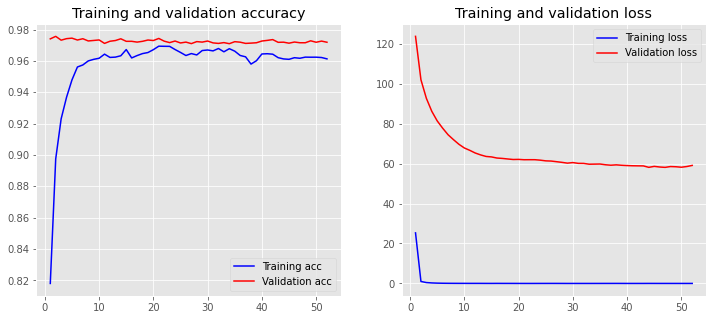

6/6 [==============================] - 3s 76ms/step
F1-score: 72.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.88,0.8979591836734694,0.888888888888889,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.15384615384615385,0.25,13.0
Brand,0.625,0.37037037037037035,0.4651162790697674,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.6129032258064516,0.95,0.7450980392156863,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6742209631728046,0.7531645569620253,0.7115097159940208,316.0
Material-Descriptor,0.45918367346938777,0.5056179775280899,0.48128342245989303,89.0
Meta,0.21428571428571427,0.23076923076923078,0.22222222222222224,13.0
Nonrecipe-Material,0.37

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3893 words (3235 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 158, 100)          712900    
                                                                 
 bidirectional_14 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 884,192
Trainable params: 884,192
Non-trainable pa

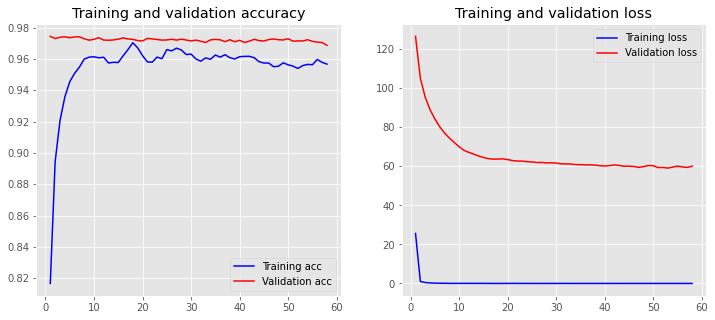

6/6 [==============================] - 3s 77ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.45454545454545453,0.7142857142857143,0.5555555555555556,7.0
Amount-Unit,0.8627450980392157,0.8979591836734694,0.8799999999999999,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.3548387096774194,0.4074074074074074,0.3793103448275862,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.8865979381443299,0.9885057471264368,0.9347826086956522,87.0
Material,0.6200527704485488,0.7436708860759493,0.6762589928057554,316.0
Material-Descriptor,0.46601941747572817,0.5393258426966292,0.5,89.0
Meta,0.21052631578947367,0.3076923076923077,0.25,13.0
Nonrecipe-Ma

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3864 words (3236 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 158, 100)          710100    
                                                                 
 bidirectional_15 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 881,392
Trainable params: 881,392
Non-trainable pa

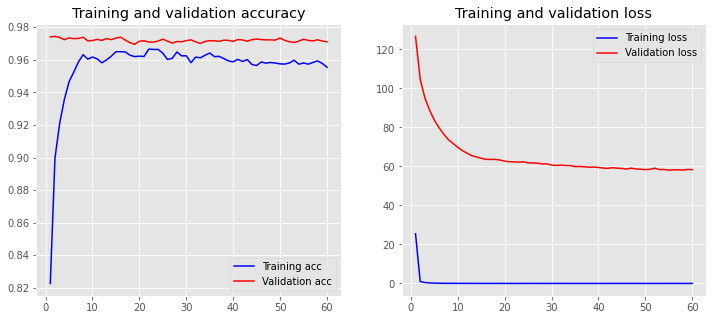

6/6 [==============================] - 4s 85ms/step
F1-score: 72.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2631578947368421,0.7142857142857143,0.3846153846153846,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.3684210526315789,0.25925925925925924,0.30434782608695654,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5517241379310345,0.8,0.6530612244897959,20.0
Condition-Type,0.16666666666666666,1.0,0.2857142857142857,1.0
Condition-Unit,0.9425287356321839,0.9425287356321839,0.9425287356321839,87.0
Material,0.6892307692307692,0.7088607594936709,0.6989079563182526,316.0
Material-Descriptor,0.5294117647058824,0.5056179775280899,0.5172413793103449,89.0
Meta,0.45454545454545453,0.38461538461538464,0.41666666666666663,13.0
Non

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3862 words (3248 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 158, 100)          711100    
                                                                 
 bidirectional_16 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 882,392
Trainable params: 882,392
Non-trainable pa

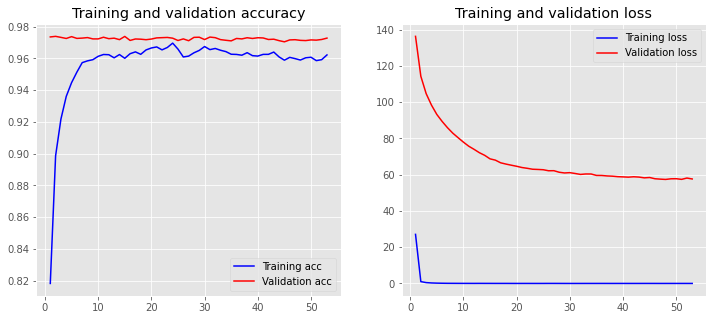

6/6 [==============================] - 4s 83ms/step
F1-score: 71.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8613861386138614,0.8877551020408163,0.8743718592964823,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.4444444444444444,0.2962962962962963,0.3555555555555555,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5862068965517241,0.85,0.6938775510204082,20.0
Condition-Type,0.07142857142857142,1.0,0.13333333333333333,1.0
Condition-Unit,0.9655172413793104,0.9655172413793104,0.9655172413793104,87.0
Material,0.6458923512747875,0.7215189873417721,0.6816143497757847,316.0
Material-Descriptor,0.42168674698795183,0.39325842696629215,0.4069767441860465,89.0
Meta,0.1875,0.23076923076923078,0.20689655172413793,13.0
Nonrecipe-Material,0.4090909090909091,0.36

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3893 words (3240 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 158, 100)          713400    
                                                                 
 bidirectional_17 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 884,692
Trainable params: 884,692
Non-trainable pa

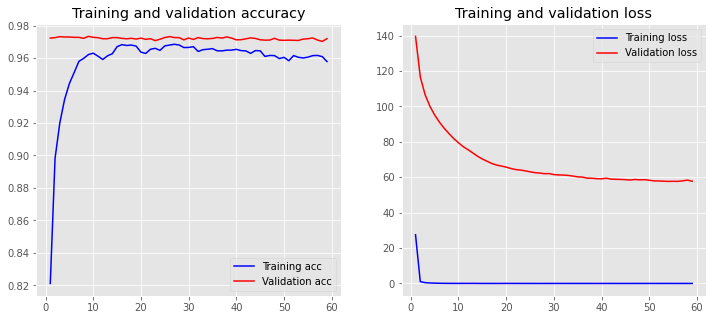

6/6 [==============================] - 3s 81ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.8380952380952381,0.8979591836734694,0.8669950738916257,98.0
Apparatus-Descriptor,0.42857142857142855,0.3333333333333333,0.375,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.47368421052631576,0.3333333333333333,0.391304347826087,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.5384615384615384,0.7,0.608695652173913,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6015424164524421,0.740506329113924,0.6638297872340425,316.0
Material-Descriptor,0.47435897435897434,0.4157303370786517,0.4431137724550898,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.3076923

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3892 words (3235 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 158, 100)          712800    
                                                                 
 bidirectional_18 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 884,092
Trainable params: 884,092
Non-trainable pa

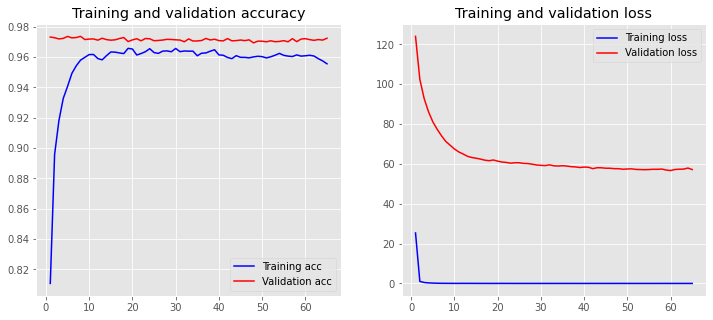

6/6 [==============================] - 4s 79ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.8130841121495327,0.8877551020408163,0.848780487804878,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.4117647058823529,0.25925925925925924,0.3181818181818182,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5454545454545454,0.9,0.679245283018868,20.0
Condition-Type,0.16666666666666666,1.0,0.2857142857142857,1.0
Condition-Unit,0.9431818181818182,0.9540229885057471,0.9485714285714286,87.0
Material,0.6463768115942029,0.7056962025316456,0.6747352496217852,316.0
Material-Descriptor,0.5119047619047619,0.48314606741573035,0.4971098265895953,89.0
Meta,0.21428571428571427,0.23076923076923078,0.22222222222222224,13.0
Nonrecipe-Material

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Converted 3872 words (3240 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 158, 100)          711300    
                                                                 
 bidirectional_19 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 882,592
Trainable params: 882,592
Non-trainable pa

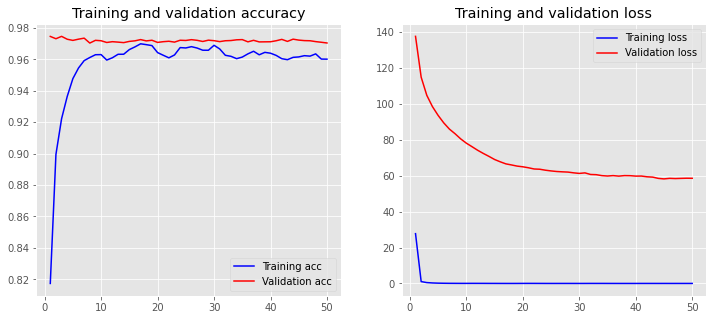

6/6 [==============================] - 4s 82ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.7142857142857143,0.588235294117647,7.0
Amount-Unit,0.8514851485148515,0.8775510204081632,0.864321608040201,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.5416666666666666,0.48148148148148145,0.5098039215686274,27.0
Characterization-Apparatus,1.0,0.18181818181818182,0.3076923076923077,11.0
Condition-Misc,0.4864864864864865,0.9,0.631578947368421,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9555555555555556,0.9885057471264368,0.9717514124293786,87.0
Material,0.6597014925373135,0.6993670886075949,0.6789554531490015,316.0
Material-Descriptor,0.45,0.5056179775280899,0.47619047619047616,89.0
Meta,0.2777777777777778,0.38461538461538464,0.3225806451612903,13.0
Nonrecipe-Material,

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4210 words (3320 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 158, 100)          753100    
                                                                 
 bidirectional_20 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 924,392
Trainable params: 924,392
Non-trainable 

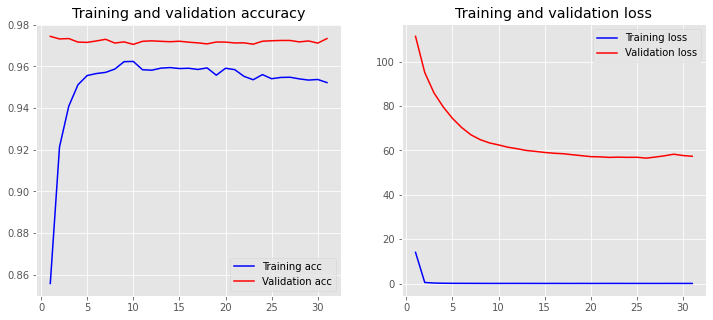

6/6 [==============================] - 4s 84ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.8712871287128713,0.8979591836734694,0.8844221105527638,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.3125,0.18518518518518517,0.2325581395348837,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6296296296296297,0.85,0.723404255319149,20.0
Condition-Type,0.05555555555555555,1.0,0.10526315789473684,1.0
Condition-Unit,0.9318181818181818,0.9425287356321839,0.9371428571428572,87.0
Material,0.6635514018691588,0.6740506329113924,0.6687598116169544,316.0
Material-Descriptor,0.45054945054945056,0.4606741573033708,0.4555555555555556,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.37142857142857144,0.52,0.433333333333

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4202 words (3333 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 158, 100)          753600    
                                                                 
 bidirectional_21 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 924,892
Trainable params: 924,892
Non-trainable 

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4206 words (3315 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          752200    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 923,492
Trainable params: 923,492
Non-trainable par

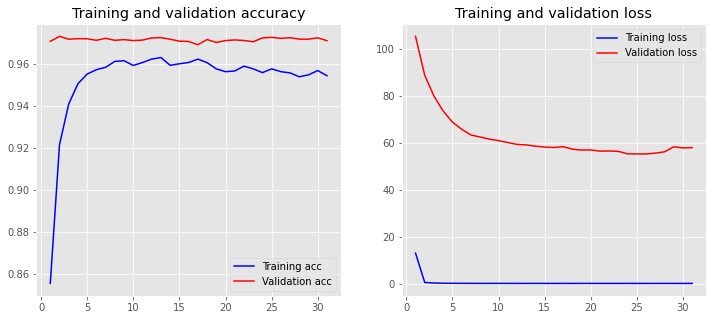

6/6 [==============================] - 3s 78ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.42857142857142855,0.4615384615384615,7.0
Amount-Unit,0.8640776699029126,0.9081632653061225,0.8855721393034826,98.0
Apparatus-Descriptor,0.6363636363636364,0.7777777777777778,0.7000000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.2777777777777778,0.18518518518518517,0.22222222222222224,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.25,1.0,0.4,1.0
Condition-Unit,0.9213483146067416,0.9425287356321839,0.9318181818181818,87.0
Material,0.6207865168539326,0.6993670886075949,0.6577380952380952,316.0
Material-Descriptor,0.46153846153846156,0.4044943820224719,0.4311377245508982,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Mater

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4231 words (3308 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          754000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 925,292
Trainable params: 925,292
Non-trainable p

In [ ]:
number_of_training_models = 9
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4172 words (3323 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          749600    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 920,892
Trainable params: 920,892
Non-trainable par

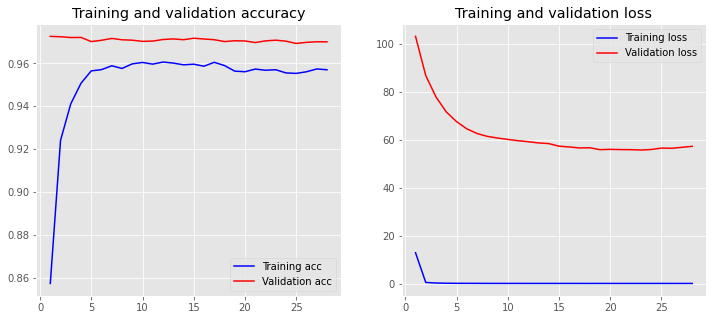

6/6 [==============================] - 4s 140ms/step
F1-score: 72.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.21052631578947367,0.5714285714285714,0.3076923076923077,7.0
Amount-Unit,0.8761904761904762,0.9387755102040817,0.9064039408866995,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5714285714285714,0.3076923076923077,0.4,13.0
Brand,0.30434782608695654,0.25925925925925924,0.27999999999999997,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5161290322580645,0.8,0.6274509803921569,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6715542521994134,0.7246835443037974,0.6971080669710806,316.0
Material-Descriptor,0.5,0.4606741573033708,0.4795321637426901,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.4090909090909091,0.36,0.382

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4208 words (3352 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          756100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 927,392
Trainable params: 927,392
Non-trainable p

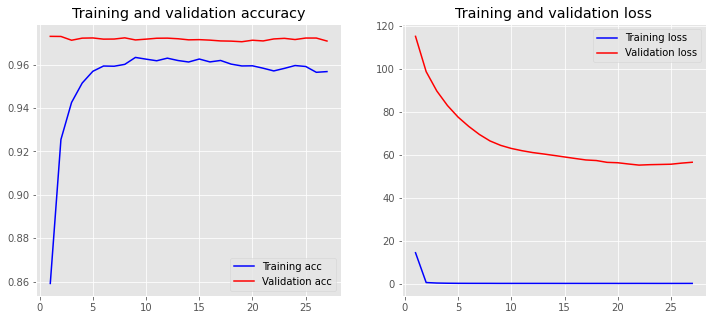

6/6 [==============================] - 4s 147ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.375,0.42857142857142855,0.39999999999999997,7.0
Amount-Unit,0.9,0.9183673469387755,0.9090909090909091,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.4090909090909091,0.3333333333333333,0.36734693877551017,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5714285714285714,0.8,0.6666666666666666,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.7157894736842105,0.6455696202531646,0.6788685524126457,316.0
Material-Descriptor,0.5,0.4044943820224719,0.4472049689440994,89.0
Meta,0.3333333333333333,0.23076923076923078,0.27272727272727276,13.0
Nonrecipe-M

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4233 words (3334 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          756800    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 928,092
Trainable params: 928,092
Non-trainable p

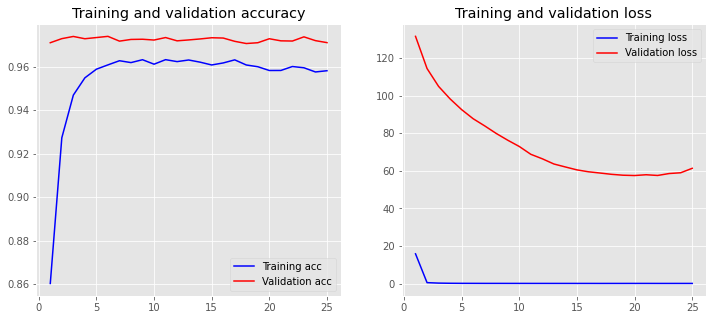

6/6 [==============================] - 4s 144ms/step
F1-score: 70.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4444444444444444,0.5714285714285714,0.5,7.0
Amount-Unit,0.84,0.8571428571428571,0.8484848484848485,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.4117647058823529,0.25925925925925924,0.3181818181818182,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.4358974358974359,0.85,0.5762711864406781,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9655172413793104,0.9655172413793104,0.9655172413793104,87.0
Material,0.7075471698113207,0.7120253164556962,0.7097791798107255,316.0
Material-Descriptor,0.4819277108433735,0.449438202247191,0.46511627906976744,89.0
Meta,0.2222222222222222,0.3076923076923077,0.2580645161290323,13.0


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4215 words (3314 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          753000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 924,292
Trainable params: 924,292
Non-trainable p

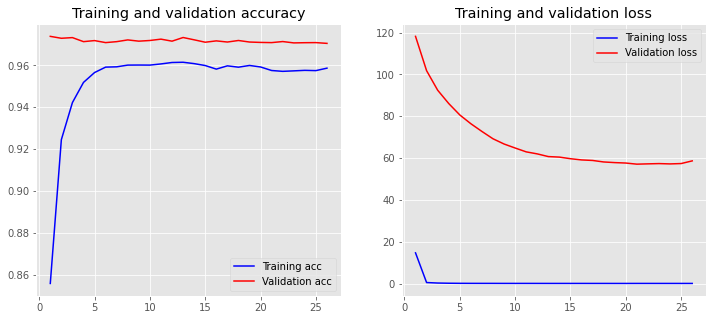

6/6 [==============================] - 4s 150ms/step
F1-score: 72.9%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.5714285714285714,0.5333333333333333,7.0
Amount-Unit,0.87,0.8877551020408163,0.8787878787878789,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.5294117647058824,0.3333333333333333,0.409090909090909,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5806451612903226,0.9,0.7058823529411764,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9431818181818182,0.9540229885057471,0.9485714285714286,87.0
Material,0.6537313432835821,0.6930379746835443,0.6728110599078341,316.0
Material-Descriptor,0.5068493150684932,0.4157303370786517,0.45679012345679015,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.3333333333333333,0.44,0.37931034482758624,25.0
Number,0.9554455445544554,0.910377358490566,0.932367149758454,212

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4239 words (3325 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          756500    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 927,792
Trainable params: 927,792
Non-trainable p

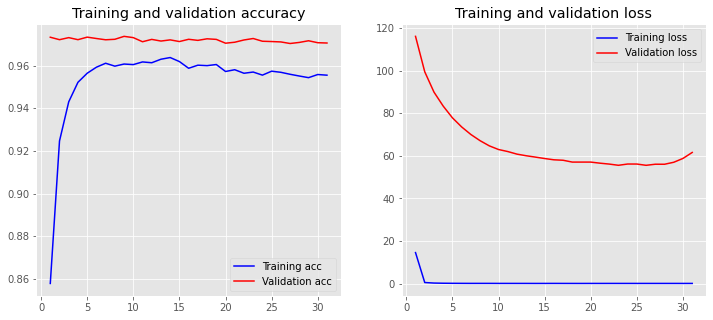

6/6 [==============================] - 4s 145ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.9157894736842105,0.8877551020408163,0.9015544041450776,98.0
Apparatus-Descriptor,0.3,0.3333333333333333,0.3157894736842105,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.4117647058823529,0.25925925925925924,0.3181818181818182,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6206896551724138,0.9,0.7346938775510204,20.0
Condition-Type,0.2,1.0,0.33333333333333337,1.0
Condition-Unit,0.9545454545454546,0.9655172413793104,0.96,87.0
Material,0.6626865671641791,0.7025316455696202,0.6820276497695852,316.0
Material-Descriptor,0.3958333333333333,0.42696629213483145,0.41081081081081083,89.0
Meta,0.3333333333333333,0.23076923076923078,0.27272727272727276,13.0
Nonrecipe-Material,0.2857142857142857,0.4,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4203 words (3330 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 158, 100)          753400    
                                                                 
 bidirectional_5 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 924,692
Trainable params: 924,692
Non-trainable p

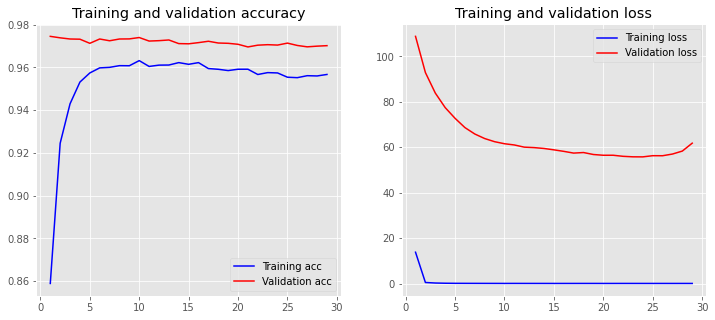

6/6 [==============================] - 4s 143ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.8627450980392157,0.8979591836734694,0.8799999999999999,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.875,0.5384615384615384,0.6666666666666667,13.0
Brand,0.38095238095238093,0.2962962962962963,0.3333333333333333,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9764705882352941,0.9540229885057471,0.9651162790697674,87.0
Material,0.6751592356687898,0.6708860759493671,0.6730158730158731,316.0
Material-Descriptor,0.4931506849315068,0.4044943820224719,0.4444444444444444,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.31428571

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4219 words (3320 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 158, 100)          754000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 925,292
Trainable params: 925,292
Non-trainable p

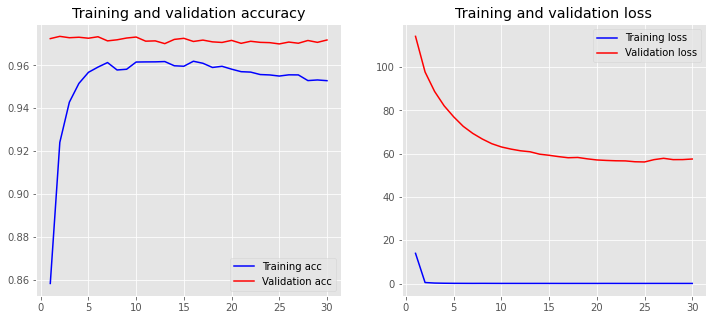

6/6 [==============================] - 4s 143ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.21428571428571427,0.42857142857142855,0.2857142857142857,7.0
Amount-Unit,0.9,0.9183673469387755,0.9090909090909091,98.0
Apparatus-Descriptor,0.36363636363636365,0.4444444444444444,0.39999999999999997,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.4444444444444444,0.3076923076923077,0.3636363636363637,13.0
Brand,0.4375,0.25925925925925924,0.3255813953488372,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.59375,0.95,0.7307692307692308,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6529411764705882,0.7025316455696202,0.6768292682926829,316.0
Material-Descriptor,0.5180722891566265,0.48314606741573035,0.5,89.0
Meta,0.21428571428571427,0.23076923076923078,0.22222222222222224,13.0
Nonrecipe-Material,0.39285714285714

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Converted 4224 words (3328 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 158, 100)          755300    
                                                                 
 bidirectional_7 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 926,592
Trainable params: 926,592
Non-trainable p

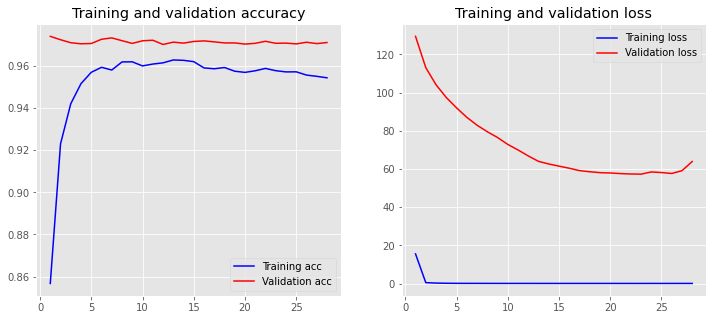

6/6 [==============================] - 5s 147ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3,0.42857142857142855,0.3529411764705882,7.0
Amount-Unit,0.8285714285714286,0.8877551020408163,0.8571428571428572,98.0
Apparatus-Descriptor,0.5555555555555556,0.5555555555555556,0.5555555555555556,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.4090909090909091,0.3333333333333333,0.36734693877551017,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.6666666666666666,0.9,0.7659574468085106,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9431818181818182,0.9540229885057471,0.9485714285714286,87.0
Material,0.6970588235294117,0.75,0.722560975609756,316.0
Material-Descriptor,0.46835443037974683,0.4157303370786517,0.4404761904761905,89.0
Meta,0.23076923076923078,0.23076923076923078,0.23076923076923078,13.0
Nonrecipe-Ma

In [ ]:
number_of_training_models = 8
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)